<a href="https://colab.research.google.com/github/V4LM0R/E.C./blob/main/BioInsp_Abejas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Estructura del Notebook (para Colab)


In [9]:
# @title Modelo de Abejas Recolectoras
# Importación de librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import random
import pandas as pd
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)
random.seed(42)

print("✓ Librerías cargadas exitosamente")

✓ Librerías cargadas exitosamente


## 2. Parámetros del Modelo

In [10]:
class ParametrosAbejas:
    def __init__(self):
        self.tamaño_territorio = 30       # Tamaño del territorio (NxN)
        self.num_abejas = 50              # Número de abejas en la colonia
        self.num_flores = 100              # Número de flores en el territorio
        self.energia_inicial = 100        # Energía inicial de cada abeja
        self.umbral_explotacion = 0.7     # Umbral para cambiar de exploración a explotación
        self.tasa_deplecion = 0.1         # Tasa de reducción de néctar cuando es visitado
        self.tasa_recoleccion = 0.3       # Cantidad de néctar que recolecta una abeja por visita
        self.tasa_regeneracion = 0.02     # Tasa de regeneración de néctar en flores
        self.max_iteraciones = 500         # Máximo número de iteraciones
        self.radio_percepcion = 3         # Radio de percepción de las abejas

    def mostrar_parametros(self):
        print("📋 PARÁMETROS DEL MODELO DE ABEJAS")
        print(f"   • Tamaño del territorio: {self.tamaño_territorio}x{self.tamaño_territorio}")
        print(f"   • Número de abejas: {self.num_abejas}")
        print(f"   • Número de flores: {self.num_flores}")
        print(f"   • Radio de percepción: {self.radio_percepcion}")
        print(f"   • Umbral explotación: {self.umbral_explotacion*100:.1f}%")
        print(f"   • Máx. iteraciones: {self.max_iteraciones}")

# Crear instancia de parámetros
params_abejas = ParametrosAbejas()
params_abejas.mostrar_parametros()

📋 PARÁMETROS DEL MODELO DE ABEJAS
   • Tamaño del territorio: 30x30
   • Número de abejas: 50
   • Número de flores: 100
   • Radio de percepción: 3
   • Umbral explotación: 70.0%
   • Máx. iteraciones: 500


## 3. Implementación del Modelo

In [11]:
class ModeloAbejas:
    def __init__(self, parametros):
        self.params = parametros
        self.territorio = None
        self.abejas = []
        self.flores = []
        self.historial_recoleccion = []
        self.historial_exploracion = []
        self.iteracion_actual = 0

    def inicializar_ecosistema(self):
        """Inicializa el territorio con abejas y flores"""
        N = self.params.tamaño_territorio

        # Crear territorio vacío
        self.territorio = np.zeros((N, N))

        # Inicializar flores (cada flor tiene posición y cantidad de néctar)
        self.flores = []
        for _ in range(self.params.num_flores):
            x, y = random.randint(0, N-1), random.randint(0, N-1)
            nectar = random.uniform(0.5, 1.0)  # Néctar inicial aleatorio
            self.flores.append({'pos': (x, y), 'nectar': nectar, 'visitada': False})
            self.territorio[x, y] = 2  # Marcar flor en el territorio

        # Inicializar abejas (cada abeja tiene posición, energía y estado)
        self.abejas = []
        colmena_pos = (N//2, N//2)  # Colmena en el centro
        for _ in range(self.params.num_abejas):
            self.abejas.append({
                'pos': colmena_pos,
                'energia': self.params.energia_inicial,
                'estado': 'explorando',  # 'explorando' o 'explotando'
                'flor_objetivo': None,
                'memoria': []  # Flores descubiertas
            })
            self.territorio[colmena_pos] = 1  # Marcar colmena

    def obtener_flores_cercanas(self, pos):
        """Obtiene flores dentro del radio de percepción"""
        x, y = pos
        radio = self.params.radio_percepcion
        flores_cercanas = []

        for flor in self.flores:
            fx, fy = flor['pos']
            distancia = np.sqrt((fx - x)**2 + (fy - y)**2)
            if distancia <= radio:
                flores_cercanas.append(flor)

        return flores_cercanas

    def mover_abeja(self, abeja):
        """Mueve una abeja según su estado"""
        x, y = abeja['pos']
        N = self.params.tamaño_territorio

        if abeja['estado'] == 'explorando':
            # Movimiento aleatorio en exploración
            dx, dy = random.choice([(0,1), (1,0), (0,-1), (-1,0), (1,1), (-1,-1), (1,-1), (-1,1)])
            new_x, new_y = x + dx, y + dy

            # Mantener dentro del territorio
            new_x = max(0, min(N-1, new_x))
            new_y = max(0, min(N-1, new_y))

            abeja['pos'] = (new_x, new_y)
            abeja['energia'] -= 1  # Costo energético

            # Verificar si encuentra flores
            flores_cercanas = self.obtener_flores_cercanas(abeja['pos'])
            for flor in flores_cercanas:
                if flor not in abeja['memoria']:
                    abeja['memoria'].append(flor)

                    # Decidir si cambiar a explotación
                    if len(abeja['memoria']) / self.params.num_flores > self.params.umbral_explotacion:
                        abeja['estado'] = 'explotando'
                        abeja['flor_objetivo'] = max(abeja['memoria'], key=lambda f: f['nectar'])

        elif abeja['estado'] == 'explotando':
            # Movimiento hacia flor objetivo
            if abeja['flor_objetivo']:
                fx, fy = abeja['flor_objetivo']['pos']

                # Movimiento en dirección a la flor
                dx = 0 if x == fx else 1 if x < fx else -1
                dy = 0 if y == fy else 1 if y < fy else -1

                new_x, new_y = x + dx, y + dy
                abeja['pos'] = (new_x, new_y)
                abeja['energia'] -= 1

                # Si llegó a la flor, recolectar néctar
                if (new_x, new_y) == (fx, fy):
                    nectar_recolectado = abeja['flor_objetivo']['nectar'] * self.params.tasa_recoleccion
                    abeja['energia'] += nectar_recolectado * 10  # Convertir néctar en energía
                    abeja['flor_objetivo']['nectar'] *= (1 - self.params.tasa_deplecion)
                    abeja['flor_objetivo']['visitada'] = True

                    # Buscar nueva flor objetivo (la mejor en memoria)
                    if abeja['memoria']:
                        abeja['flor_objetivo'] = max(abeja['memoria'], key=lambda f: f['nectar'])

    def actualizar_flores(self):
        """Regenera néctar en las flores"""
        for flor in self.flores:
            flor['nectar'] = min(1.0, flor['nectar'] + self.params.tasa_regeneracion)
            flor['visitada'] = False

    def calcular_metricas(self):
        """Calcula métricas de recolección y exploración"""
        nectar_total = sum(f['nectar'] for f in self.flores)
        abejas_explorando = sum(1 for a in self.abejas if a['estado'] == 'explorando')
        proporcion_exploracion = abejas_explorando / len(self.abejas)

        return nectar_total, proporcion_exploracion

    def simular(self, mostrar_progreso=True):
        """Ejecuta la simulación completa"""
        print("🐝 Iniciando simulación del Modelo de Abejas...")

        # Inicializar ecosistema
        self.inicializar_ecosistema()

        # Calcular métricas iniciales
        nectar_inicial, exploracion_inicial = self.calcular_metricas()
        self.historial_recoleccion.append(nectar_inicial)
        self.historial_exploracion.append(exploracion_inicial)

        if mostrar_progreso:
            print(f"Estado inicial - Néctar total: {nectar_inicial:.1f}, Abejas explorando: {exploracion_inicial*100:.1f}%")

        # Ejecutar iteraciones
        for iteracion in range(self.params.max_iteraciones):
            self.iteracion_actual = iteracion + 1

            # Mover cada abeja
            for abeja in self.abejas:
                self.mover_abeja(abeja)

                # Si energía es crítica, volver a la colmena
                if abeja['energia'] < 20:
                    abeja['pos'] = (self.params.tamaño_territorio//2, self.params.tamaño_territorio//2)
                    abeja['energia'] = self.params.energia_inicial
                    abeja['estado'] = 'explorando'
                    abeja['flor_objetivo'] = None

            # Actualizar estado de las flores
            self.actualizar_flores()

            # Calcular métricas
            nectar, exploracion = self.calcular_metricas()
            self.historial_recoleccion.append(nectar)
            self.historial_exploracion.append(exploracion)

            # Mostrar progreso
            if mostrar_progreso and (iteracion + 1) % 50 == 0:
                print(f"Iteración {iteracion + 1:3d} - Néctar: {nectar:.1f}, Exploración: {exploracion*100:.1f}%")

        # Resumen final
        nectar_final, exploracion_final = self.calcular_metricas()
        print(f"\n📊 RESULTADOS FINALES:")
        print(f"   • Iteraciones ejecutadas: {self.iteracion_actual}")
        print(f"   • Néctar recolectado: {nectar_inicial - nectar_final:.1f} unidades")
        print(f"   • Abejas explorando al final: {exploracion_final*100:.1f}%")

## 4. Funciones de Visualización

In [12]:
def visualizar_territorio(modelo, titulo="Estado de la Simulación"):
    """Visualiza el estado actual del territorio"""
    fig, ax = plt.subplots(figsize=(10, 10))
    N = modelo.params.tamaño_territorio

    # Crear matriz para visualización
    visual = np.zeros((N, N))

    # Marcar flores (intensidad según néctar disponible)
    for flor in modelo.flores:
        x, y = flor['pos']
        visual[x, y] = flor['nectar'] + 1  # Rango 1-2

    # Marcar abejas (3 para exploradoras, 4 para explotadoras)
    for abeja in modelo.abejas:
        x, y = abeja['pos']
        visual[x, y] = 3 if abeja['estado'] == 'explorando' else 4

    # Marcar colmena (centro)
    centro = N//2
    visual[centro, centro] = 5

    # Mostrar territorio
    cmap = plt.cm.get_cmap('viridis', 5)
    im = ax.imshow(visual, cmap=cmap, vmin=0, vmax=5)

    # Configuración
    ax.set_title(f"{titulo}\nIteración: {modelo.iteracion_actual}", fontsize=14)
    ax.set_xlabel("Coordenada X")
    ax.set_ylabel("Coordenada Y")

    # Leyenda
    from matplotlib.patches import Patch
    elementos = [
        Patch(facecolor='black', label='Vacío'),
        Patch(facecolor='yellow', label='Flor (poco néctar)'),
        Patch(facecolor='green', label='Flor (mucho néctar)'),
        Patch(facecolor='blue', label='Abeja exploradora'),

    ]
    ax.legend(handles=elementos, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

def visualizar_evolucion(modelo):
    """Visualiza la evolución de las métricas"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    iteraciones = range(len(modelo.historial_recoleccion))

    # Gráfico de néctar
    ax1.plot(iteraciones, modelo.historial_recoleccion, color='green')
    ax1.set_title('Néctar Total en Flores', fontsize=14)
    ax1.set_xlabel('Iteración')
    ax1.set_ylabel('Néctar disponible')
    ax1.grid(True, alpha=0.3)

    # Gráfico de exploración
    ax2.plot(iteraciones, modelo.historial_exploracion, color='blue')
    ax2.set_title('Proporción de Abejas Exploradoras', fontsize=14)
    ax2.set_xlabel('Iteración')
    ax2.set_ylabel('Porcentaje explorando')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

## 5. Ejecución del Modelo


In [13]:
# Crear y ejecutar modelo
print("🔬 EXPERIMENTO: Simulación de Abejas Recolectoras")
print("=" * 50)

modelo_abejas = ModeloAbejas(params_abejas)
modelo_abejas.simular()


🔬 EXPERIMENTO: Simulación de Abejas Recolectoras
🐝 Iniciando simulación del Modelo de Abejas...
Estado inicial - Néctar total: 73.4, Abejas explorando: 100.0%
Iteración  50 - Néctar: 100.0, Exploración: 100.0%
Iteración 100 - Néctar: 100.0, Exploración: 100.0%
Iteración 150 - Néctar: 100.0, Exploración: 100.0%
Iteración 200 - Néctar: 100.0, Exploración: 100.0%
Iteración 250 - Néctar: 100.0, Exploración: 100.0%
Iteración 300 - Néctar: 100.0, Exploración: 100.0%
Iteración 350 - Néctar: 100.0, Exploración: 100.0%
Iteración 400 - Néctar: 100.0, Exploración: 100.0%
Iteración 450 - Néctar: 100.0, Exploración: 100.0%
Iteración 500 - Néctar: 100.0, Exploración: 100.0%

📊 RESULTADOS FINALES:
   • Iteraciones ejecutadas: 500
   • Néctar recolectado: -26.6 unidades
   • Abejas explorando al final: 100.0%



📊 Visualizando resultados...


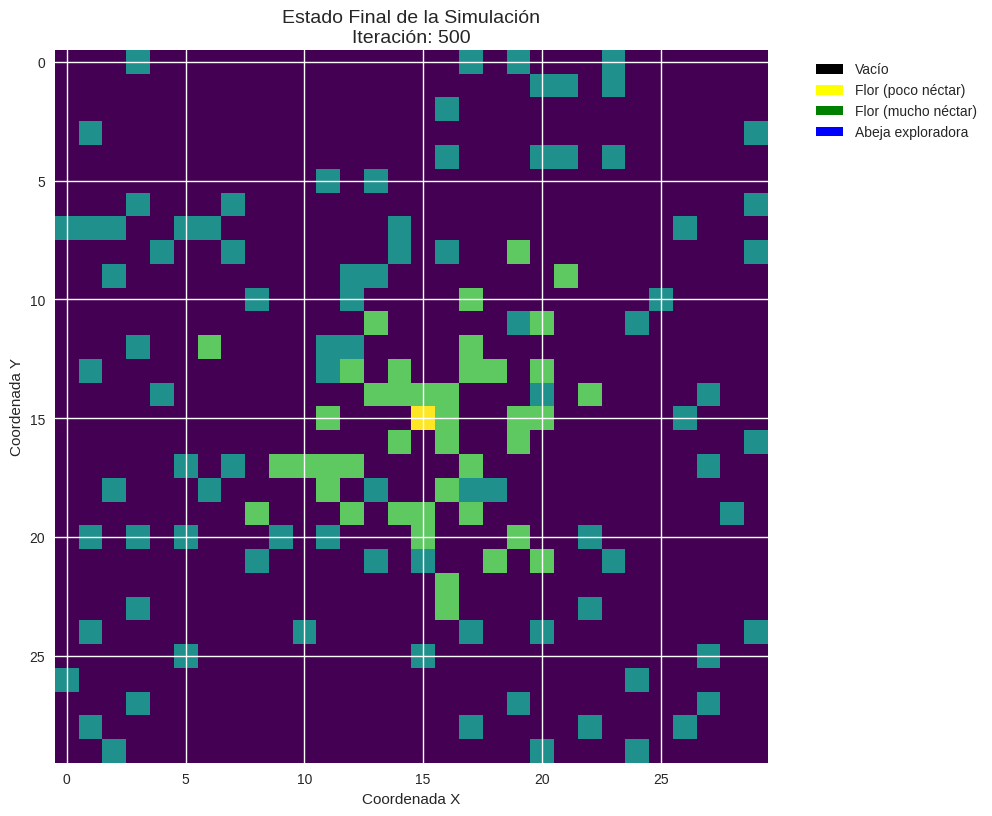

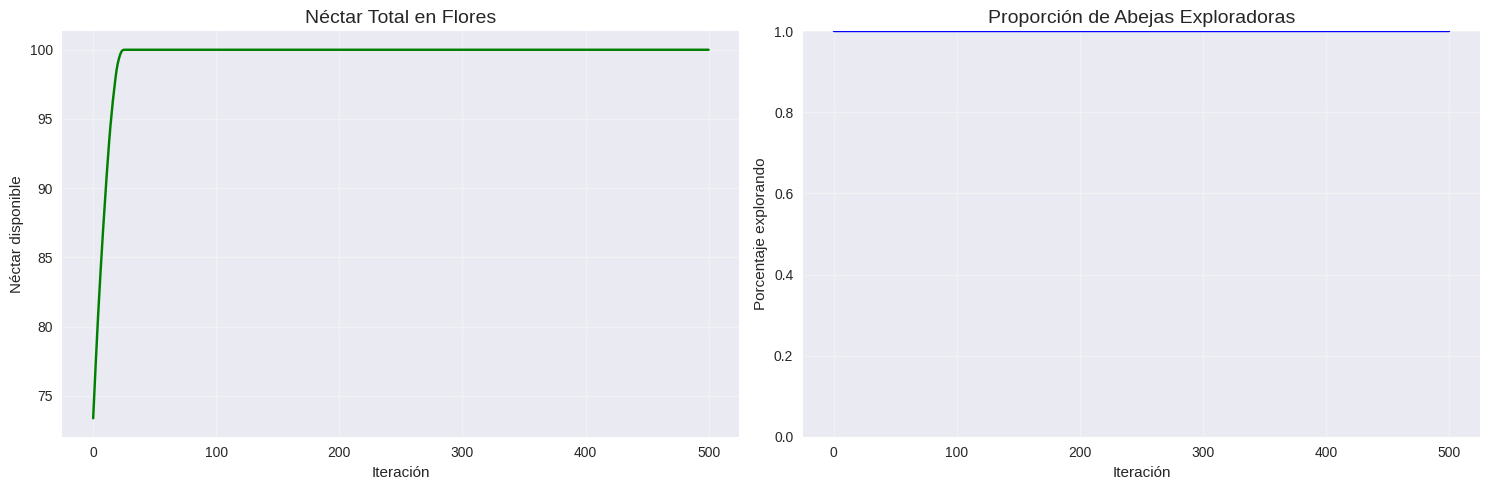

In [14]:
# Visualizar resultados
print("\n📊 Visualizando resultados...")
visualizar_territorio(modelo_abejas, "Estado Final de la Simulación")
visualizar_evolucion(modelo_abejas)